In [12]:
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import DB_CONFIG


In [13]:
conn = psycopg2.connect(**DB_CONFIG)

if conn.closed == 0:
    print("Connected to DB")

all_points_sql = 'SELECT * FROM vessels_points_jan LIMIT 100000'

all_points_gdf =  gpd.GeoDataFrame.from_postgis(all_points_sql, conn, geom_col='geom')

Connected to DB


In [14]:
all_points_gdf['datetime'] = pd.to_datetime(all_points_gdf['timest'],unit='ms')


In [15]:
all_points_gdf = all_points_gdf.sort_values(by=['mmsi','datetime'], ascending=[True,True])
all_points_gdf.head()


,timest,dates,typee,mmsi,status,heading,turn,speed,course,geom,datetime
90,1.516925e+12,2018-01-26 01:03:08,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:03:08
147,1.516925e+12,2018-01-26 01:03:18,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:03:18
271,1.516925e+12,2018-01-26 01:04:29,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:04:29
321,1.516925e+12,2018-01-26 01:04:57,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:04:57
340,1.516925e+12,2018-01-26 01:05:08,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:05:08


In [16]:
cleansed_gdf = all_points_gdf.drop_duplicates(subset=['mmsi','datetime'])
print('Number of records before removing duplicates: {}'.format(len(all_points_gdf)))
print('Number of records after removing duplicates: {}'.format(len(cleansed_gdf)))
cleansed_gdf.head()

Number of records before removing duplicates: 500000
Number of records after removing duplicates: 499638


,timest,dates,typee,mmsi,status,heading,turn,speed,course,geom,datetime
90,1.516925e+12,2018-01-26 01:03:08,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:03:08
147,1.516925e+12,2018-01-26 01:03:18,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:03:18
271,1.516925e+12,2018-01-26 01:04:29,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:04:29
321,1.516925e+12,2018-01-26 01:04:57,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:04:57
340,1.516925e+12,2018-01-26 01:05:08,None,0,None,NaN,None,0.0,0.0,POINT (23.60814 37.95577),2018-01-26 00:05:08


In [17]:
def haversive_dist(p1,p2):
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = p2.x - p1.x
    dlat = p2.y - p1.y

    a = np.sin(dlat/2.0)**2 + np.cos(p1.y) * np.cos(p2.y) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km
    


In [18]:
def calculate_speed(df):
    """Calculating speed of a vessel for each point"""
    
    first_row = df.iloc[0,:]
    for index, row in df[1:].iterrows():
        second_row = row.copy()
        hav_dist = haversive_dist(first_row.geom,second_row.geom)
        df.loc[index,'distance_from_prev'] = hav_dist
        time_diff = df.loc[index,'time_diff']
        if pd.notna(time_diff) and time_diff != 0:
            speed = hav_dist/time_diff
            df.loc[index,'velocity'] = speed
        first_row = second_row.copy()
    #print('Group finished')
    return df
        
        

In [19]:
cleansed_gdf['velocity'] = np.nan
cleansed_gdf['distance_from_prev'] = np.nan
cleansed_gdf['time_diff'] = cleansed_gdf['datetime'].diff().dt.total_seconds()
cleansed_gdf = cleansed_gdf.groupby('mmsi',group_keys=False).apply(lambda group : calculate_speed(group))
cleansed_gdf.dropna(subset=['velocity'],inplace=True)

C:\Users\Tackk-is\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
len(cleansed_gdf)

499345

In [24]:
x_axis = []
for i in range(0,51):
    x_axis.append(i*5)

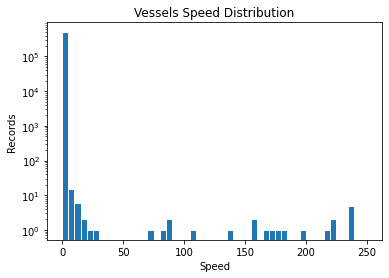

In [25]:
plt.figure('Vessels Speed Distribution')
plt.title('Vessels Speed Distribution')
plt.hist(tmp['velocity'], log=True ,bins = x_axis, edgecolor = 'white')
plt.xlabel('Speed')
plt.ylabel('Records')
plt.show()

In [26]:
len(cleansed_gdf['mmsi'].unique())

293

In [47]:
def del_speed_outlier(df):
    outliers = []
    mmsis = df['mmsi'].unique()
    for i,mmsi in enumerate(mmsis):
        df = df.drop(df[df['velocity'] > 60].index)
    return df

In [48]:

cleasned_gdf = del_speed_outlier(cleansed_gdf)

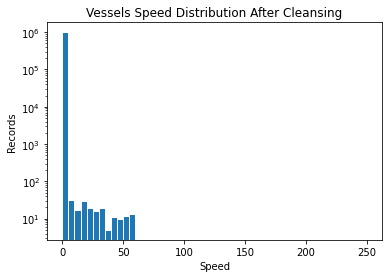

In [76]:
plt.figure('Vessels Speed Distribution After Cleansing')
plt.title('Vessels Speed Distribution After Cleansing')
plt.hist(cleansed_gdf['velocity'], log=True ,bins = x_axis, edgecolor = 'white')
plt.xlabel('Speed')
plt.ylabel('Records')
plt.show()